We are particularly interested in the relation between all other features and sale price, so we have the following options:
(1) using all data directly
By feeding all data into the model we could (a) build a predictor to predict the sale price, or (b) discretize the sale price into several interval, then build a classifier to predict the sale price interval, output the mean of the interval as the predicted sale price.
(2) pre-processing the data using Anomaly Detection and Clustering
Using Anomaly detection to filter out some data points lying outside of the "normal" region since they would have more or less influence on the predictor/classifier. And we assume the outliers will have more influence on predictor than classifier.
And we can cluster data into different groups and for each group, we are going to train a predictor/classifier to perform the task.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvPath = "data/"
file1 = "Beijing_housing_price.csv"
file2 = "rollingsales_bronx.csv"
file3 = "rollingsales_brooklyn.csv"
file4 = "rollingsales_manhattan.csv"
file5 = "rollingsales_queens.csv"
file6 = "rollingsales_statenisland.csv"

df_beijing      = pd.DataFrame(pd.read_csv(csvPath + file1))
df_bronx        = pd.DataFrame(pd.read_csv(csvPath + file2, thousands=',')).dropna()
df_brooklyn     = pd.DataFrame(pd.read_csv(csvPath + file3, thousands=',')).dropna()
df_manhattan    = pd.DataFrame(pd.read_csv(csvPath + file4, thousands=',')).dropna()
df_queens       = pd.DataFrame(pd.read_csv(csvPath + file5, thousands=',')).dropna()
df_statenisland = pd.DataFrame(pd.read_csv(csvPath + file6, thousands=',')).dropna()


# Visualization
(1) pick some feature that seems meaningful and show some data points

(2) compare Beijing and NYC

## Beijing

clustering and visualization by geographic location, only use a subset of the data

In [2]:
print(df_beijing.head())
df_beijing_subset = df_beijing[['Lng','Lat', 'price']].iloc[0:500,:].copy()

          Lng        Lat tradeTime  followers  totalPrice  price  square  \
0  116.475489  40.019520    8/9/16        106       415.0  31680  131.00   
1  116.453917  39.881534   7/28/16        126       575.0  43436  132.38   
2  116.561978  39.877145  12/11/16         48      1030.0  52021  198.00   
3  116.438010  40.076114   9/30/16        138       297.5  22202  134.00   
4  116.428392  39.886229   8/28/16        286       392.0  48396   81.00   

   livingRoom  drawingRoom  kitchen  bathRoom  buildingType constructionTime  \
0           2            1        1         1             1             2005   
1           2            2        1         2             1             2004   
2           3            2        1         3             4             2005   
3           3            1        1         1             1             2008   
4           2            1        1         1             4             1960   

   renovationCondition  buildingStructure  ladderRatio  elevat

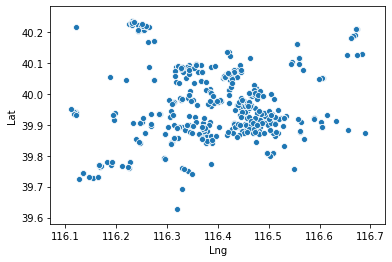

In [3]:
ax = sns.scatterplot(x='Lng', y='Lat', data=df_beijing_subset)

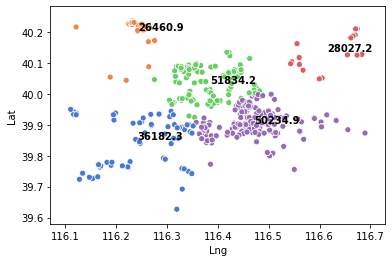

In [4]:
from sklearn.cluster import KMeans
CONST_n_clusters = 5
KMC = KMeans(n_clusters = CONST_n_clusters)
KMC.fit(df_beijing_subset[['Lng','Lat']])
KMC_pred = KMC.predict(df_beijing_subset[['Lng','Lat']])
df_beijing_subset['cluster'] = KMC_pred 
ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=CONST_n_clusters), 
                     legend = False,
                     data=df_beijing_subset)
for i in df_beijing_subset['cluster'].unique():
    df_average = df_beijing_subset[df_beijing_subset['cluster'] == i].mean()
    ax.text(df_average.iloc[0], df_average.iloc[1], str(df_average.iloc[2].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

This is very interesting and promising! 
We know that the location is a key fact of housing price, and the central area of Beijing is the most expensive region in the city. We can easily find that the average price (per square) of all clusters drops when the cluster goes away from the center of the fig, so the result is consistent to our knowledge.

We can also see that the average price differs a lot, which means we might want to consider using different predictor to predict the housing price for each cluster.


## NYC

since NYC data doesn't have geographic info, instead they contain address and zip code, which is indirect link to location. Here we are going to visualize the area and build year of the house to see if a similar relation to price exists. 

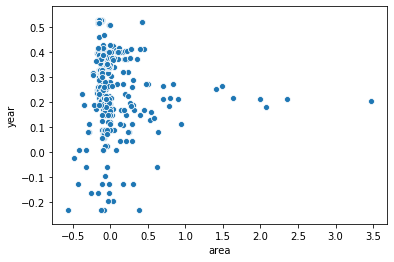

In [97]:
from sklearn.preprocessing import scale
df_list = [df_bronx, df_brooklyn, df_manhattan, df_queens, df_statenisland]
for i in range(len(df_list)):
    df = df_list[i]
    df = df[df['GROSS SQUARE FEET'] > 0].copy()
    df['price'] = df[' SALE PRICE '] / df['GROSS SQUARE FEET']
    df['year'] = scale(np.array(df['YEAR BUILT']).reshape(-1, 1))
    df['area'] = scale(np.array(df['GROSS SQUARE FEET']).reshape(-1, 1))
    df_list[i] = df
n_sam = 100
df_subset = []
for this_df in df_list:
    temp = this_df[['area','year', 'YEAR BUILT', 'price']]
    df_subset.append(temp[(temp['price']>10) & (temp['YEAR BUILT']>1000)].iloc[0:n_sam,:].copy())
df_NYC_subset = pd.concat(df_subset, ignore_index=True)
print()
ax = sns.scatterplot(x='area', y='year', data=df_NYC_subset)

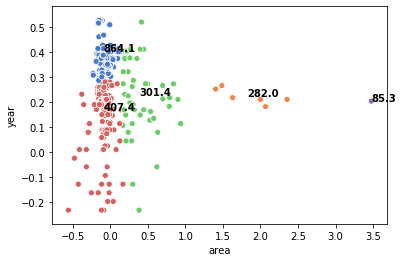

In [99]:
another_KMC = KMeans(n_clusters = CONST_n_clusters)
another_KMC.fit(df_NYC_subset[['area','year']])
another_pred = another_KMC.predict(df_NYC_subset[['area','year']])

df_NYC_subset['cluster'] = another_pred 
ax = sns.scatterplot(x='area', y='year', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=CONST_n_clusters), 
                     legend = False,
                     data=df_NYC_subset)
for i in df_NYC_subset['cluster'].unique():
    df_average = df_NYC_subset[df_NYC_subset['cluster'] == i].mean()
    ax.text(df_average['area'], df_average['year'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')


Seems okay, but not as good as geographic feature. 
The average price of each cluster changes along with the area of the house implies that, smaller house is actually more expensive, maybe.

We should also notice that the number of cluster here might not work for the best, 4 seems better.

# Model: K-means

## Beijing
As shown before, it's a little tricky how to choose the number of clusters when using K-means. Here we trial and error and find that 13 might be a good number as it clustering the data in the way:

(1) the clustering result is similar to actual district in Beijing.

(2) the average price varies a lot even the clusters are geographically next to each other.




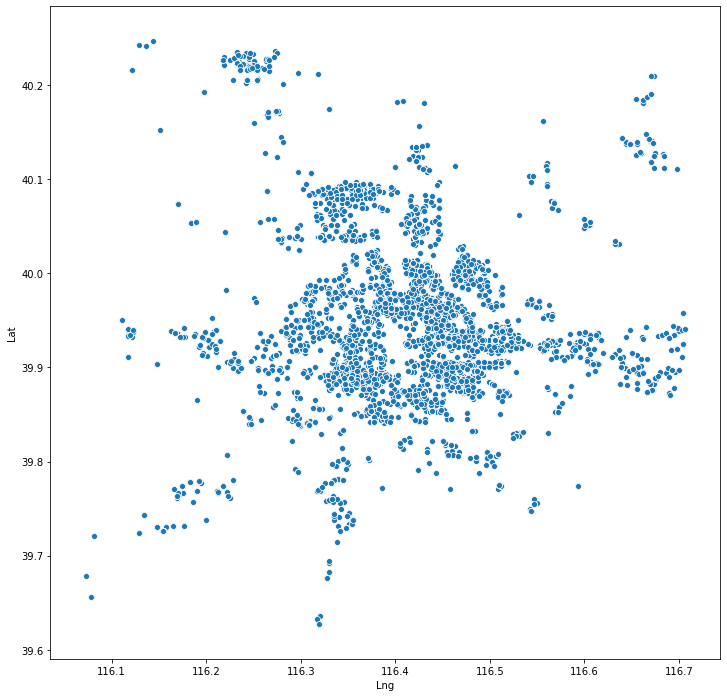

In [19]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='Lng', y='Lat', data=df_beijing)

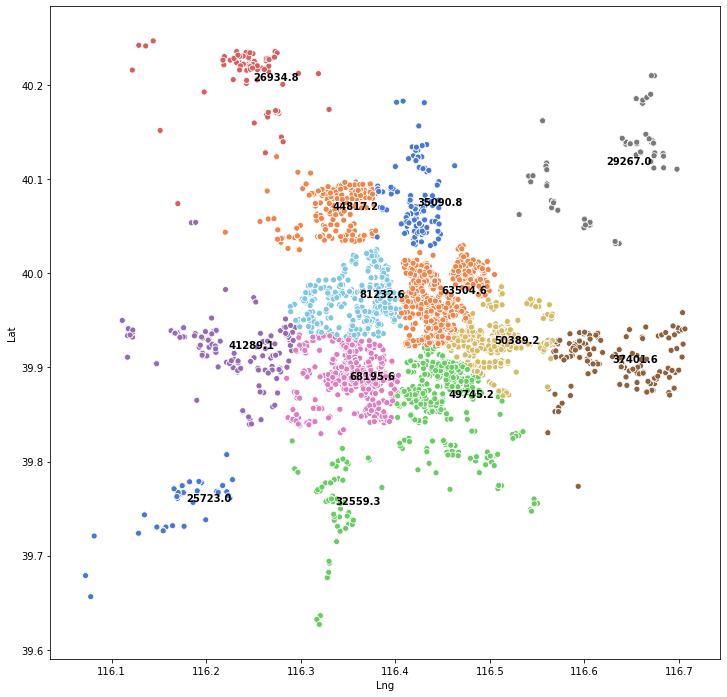

In [52]:
N_clusters = 13
KMC_beijing = KMeans(n_clusters = N_clusters)
KMC_beijing.fit(df_beijing[['Lng','Lat']])
KMC_beijing_pred = KMC_beijing.predict(df_beijing[['Lng','Lat']])
df_beijing['cluster'] = KMC_beijing_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=N_clusters), 
                     legend = False,
                     data=df_beijing)
for i in df_beijing['cluster'].unique():
    df_average = df_beijing[df_beijing['cluster'] == i].mean()
    ax.text(df_average['Lng'], df_average['Lat'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

## NYC
Based on the obeservation, we think 7 might be a good choice of the number of cluster to try.

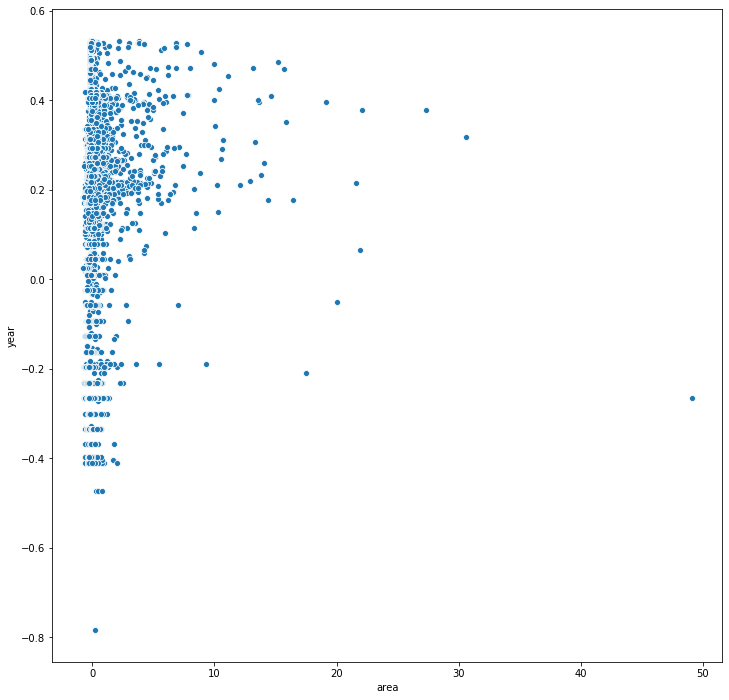

In [103]:
df_dist = []
for this_df in df_list:
    df_dist.append(this_df[(this_df['price']>10) & (this_df['YEAR BUILT']>1200) & (this_df['GROSS SQUARE FEET']>100) &(this_df['GROSS SQUARE FEET']<1000000)].copy())
df_NYC = pd.concat(df_dist, ignore_index=True)
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='area', y='year', data=df_NYC)

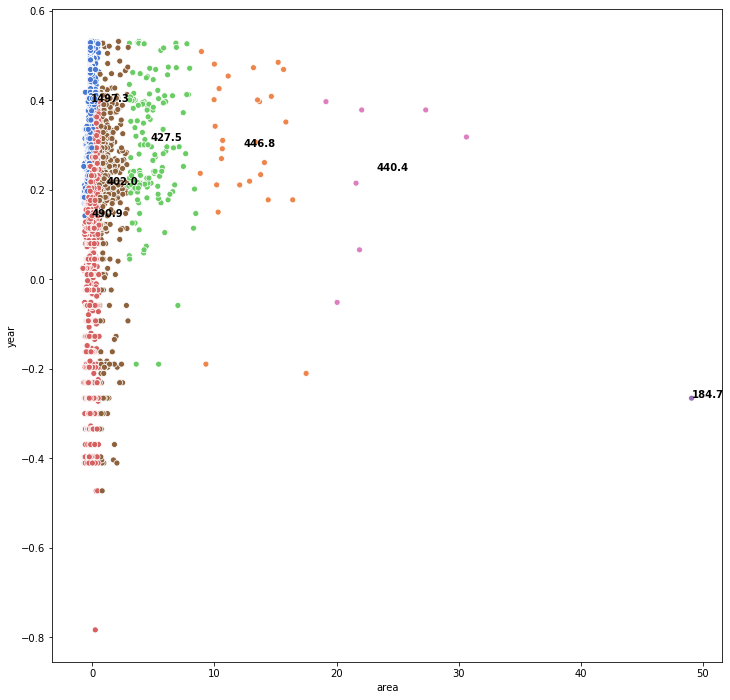

In [104]:
another_N_clusters = 7
KMC_NYC = KMeans(n_clusters = another_N_clusters)
KMC_NYC.fit(df_NYC[['area','year']])
KMC_NYC_pred = KMC_NYC.predict(df_NYC[['area','year']])
plt.figure(figsize=(12, 12))
df_NYC['cluster'] = KMC_NYC_pred 
ax = sns.scatterplot(x='area', y='year', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=another_N_clusters), 
                     legend = False,
                     data=df_NYC)
for i in df_NYC['cluster'].unique():
    df_average = df_NYC[df_NYC['cluster'] == i].mean()
    ax.text(df_average['area'], df_average['year'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

Again, the build year doesn't seem a good feature to use when clustering.

# Model: Birch

## Beijing

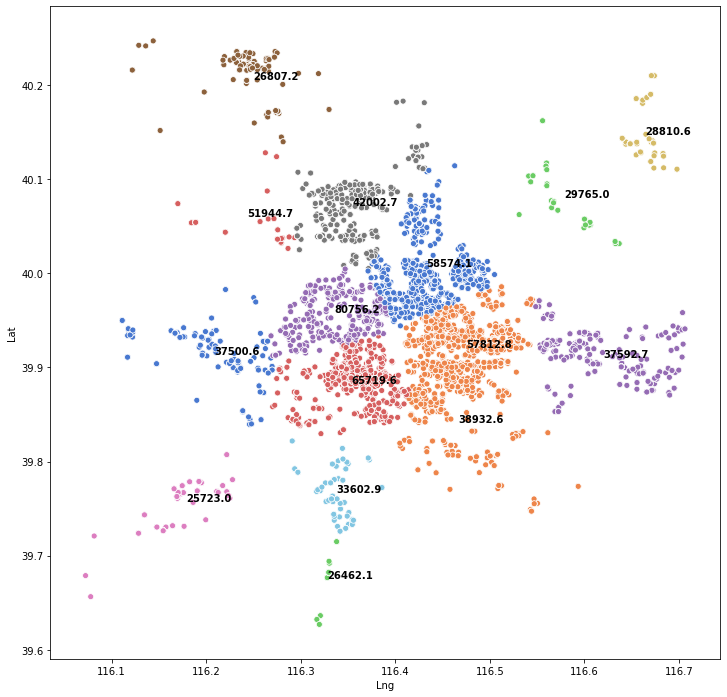

In [84]:
from sklearn.cluster import Birch
MSC_beijing = Birch(branching_factor=50, n_clusters=None, threshold=0.06, compute_labels=True)
MSC_beijing.fit(df_beijing[['Lng','Lat']])
MSC_beijing_pred = MSC_beijing.predict(df_beijing[['Lng','Lat']])
df_beijing['cluster1'] = MSC_beijing_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster1', 
                     palette=sns.color_palette("muted", n_colors=len(df_beijing['cluster1'].unique())), 
                     legend = False,
                     data=df_beijing)
for i in df_beijing['cluster1'].unique():
    df_average = df_beijing[df_beijing['cluster1'] == i].mean()
    ax.text(df_average['Lng'], df_average['Lat'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

It's similar to K-means but not quite the same, we will compare the influence of different clustering on the performance of perdictor.

## NYC

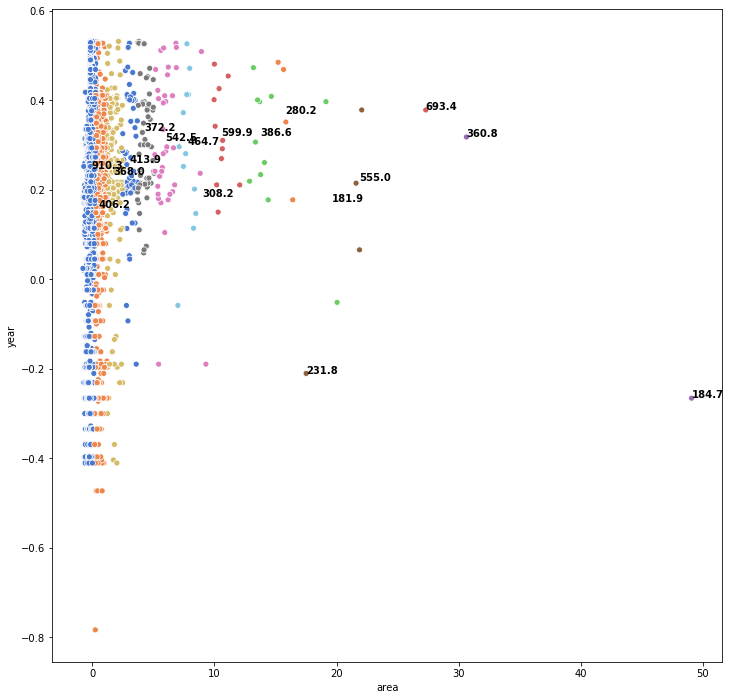

In [111]:
MSC_NYC = Birch(branching_factor=50, n_clusters=None, threshold=0.6, compute_labels=True)
MSC_NYC.fit(df_NYC[['area','year']])
MSC_NYC_pred = MSC_NYC.predict(df_NYC[['area','year']])
df_NYC['cluster1'] = MSC_NYC_pred  
plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='area', y='year', hue='cluster1', 
                     palette=sns.color_palette("muted", n_colors=len(df_NYC['cluster1'].unique())), 
                     legend = False,
                     data=df_NYC)
for i in df_NYC['cluster1'].unique():
    df_average = df_NYC[df_NYC['cluster1'] == i].mean()
    ax.text(df_average['area'], df_average['year'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

Again, area seems dominate the clustering.